## <span style="color:White; font-size:24px; font-weight:bold;">About Project</span>

A marketing company conducted an A/B test to evaluate whether a new advertisement could improve conversion rates. In the experiment, the treatment group was exposed to the new ads, while the control group was shown either a Public Service Announcement (PSA) or no content at all, placed in the same location and format as the ads.

This project analyzes the collected data to determine whether launching the new ads would be a worthwhile business decision. The analysis begins with an exploratory data analysis (EDA) using SQL, Matplotlib, and Seaborn to generate clear and insightful visualizations, enabling a deeper understanding of the campaign’s performance. Subsequently, hypothesis testing is performed to assess whether the observed differences between the treatment and control groups are statistically significant, supporting data-driven decision-making.



## <span style="color:White; font-size:24px; font-weight:bold;">Table of Content</span>

1. Libraries
2. Loading Data
3. Exploratory Data Analysis
   - 3.1 Basic Information
   - 3.2 Analysis per Testing Group
   - 3.3 Conversion Rate by Day of the Week & Hour of the Day
   - 3.4 Most Ads Seen by Day of the Week
   - 3.5 Top 10 Most Ads Seen by Day and Hour - Treatment vs. Control
4. Hypothesis Test
    - 4.1 Conversion Rate
    - 4.2 Total Ads
5.  Key Findings & Recommendations
      

## <span style="color:White; font-size:24px; font-weight:bold;">1. Libraries</span>

In [1]:
import kagglehub
import pandas as pd
import sqlite3
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Download latest version
path = kagglehub.dataset_download("faviovaz/marketing-ab-testing")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/marketing-ab-testing


## <span style="color:White; font-size:24px; font-weight:bold;">2. Loading Data</span>

In [2]:
base_df = pd.read_csv("/kaggle/input/marketing-ab-testing/marketing_AB.csv")
base_df.columns = [col.replace(' ','_') for col in base_df.columns]
base_df = base_df.rename(columns={"Unnamed:_0": "index"})

# connect to SQLite
conn = sqlite3.connect("mydb.db")

# to sql db
base_df.to_sql("ab_testing", conn, if_exists="replace", index=False)

588101

## <span style="color:White; font-size:24px; font-weight:bold;">3. EDA </span>

### 3.1 Basic Information

First, I examined the structure of the dataset and calculated key descriptive statistics for each variable to gain an initial understanding of the data distribution and identify any potential anomalies or data quality issues.

In [3]:
# Basics:
print("First 10 rows of dataset:")
display(base_df.head(10))

print("\n\nData Dimensions:")
display(base_df.shape)

print("\n\ninformation about the data:")
display(base_df.info())

print("\n\nstatistical measures of each column:")
display(base_df[['total_ads','most_ads_hour']].describe().T)

First 10 rows of dataset:


,index,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14
5,5,1137664,ad,False,734,Saturday,10
6,6,1116205,ad,False,264,Wednesday,13
7,7,1496843,ad,False,17,Sunday,18
8,8,1448851,ad,False,21,Tuesday,19
9,9,1446284,ad,False,142,Monday,14




Data Dimensions:


(588101, 7)



information about the data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   index          588101 non-null  int64 
 1   user_id        588101 non-null  int64 
 2   test_group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total_ads      588101 non-null  int64 
 5   most_ads_day   588101 non-null  object
 6   most_ads_hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


None



statistical measures of each column:


,count,mean,std,min,25%,50%,75%,max
total_ads,588101.0,24.820876,43.715181,1.0,4.0,13.0,27.0,2065.0
most_ads_hour,588101.0,14.469061,4.834634,0.0,11.0,14.0,18.0,23.0


In [4]:
### check distinct user count
query = """
  SELECT count(distinct user_id) as user_cnt
    FROM ab_testing
"""

df = pd.read_sql_query(query, conn)
df.head()

,user_cnt
0,588101


### 3.2 Analysis per Testing Group

Next, I focused on comparing the treatment and control groups by calculating two key performance metrics for each: the conversion rate and the average number of ads viewed. These measures provide an initial indication of user engagement and potential campaign effectiveness before conducting formal statistical testing.

In [5]:
### analysis per testing group
query = """
  SELECT 
  test_group,
  count(distinct user_id) as user_cnt,
  round(avg(converted)*100,2) || '%' as conversion_pct,
  sum(total_ads) as total_ads,
  round(avg(total_ads),2) as avg_ads
    FROM ab_testing
    group by 1
"""

df = pd.read_sql_query(query, conn)
df.head()



,test_group,user_cnt,conversion_pct,total_ads,avg_ads
0,ad,564577,2.55%,14014701,24.82
1,psa,23524,1.79%,582481,24.76


From the summary table above, it is evident that the majority of participants were assigned to the treatment group. However, the average number of ads viewed per person was nearly identical between the two groups. This suggests that the A/B test was implemented correctly, with balanced exposure in terms of ad placement and frequency.

While the conversion rate for the ad group is higher than that of the PSA group, this observed difference alone does not necessarily prove that the ad outperforms the PSA. Further statistical testing is required to determine whether the difference is statistically significant and not simply due to random variation.

### 3.3  Conversion Rate by Day of the Week & Hour of the Day

Let's take a closer look on conversion rate. 
How it varied across different days of the week and hours of the day for each group? This breakdown helps identify potential temporal patterns in user behavior and determine whether the ad and PSA groups responded differently depending on when they were exposed to the content.

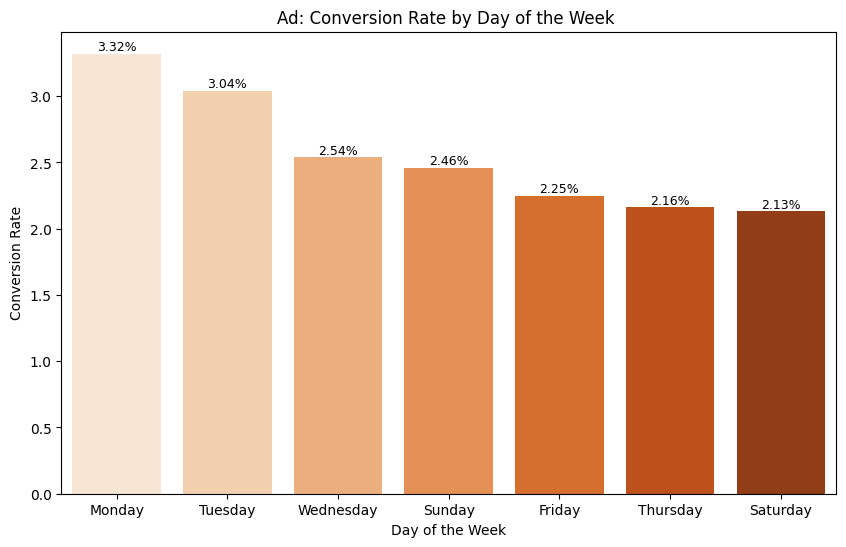

In [6]:
# ad group: conversion rate by day of the week 
query ="""
    SELECT 
      most_ads_day,
      round(avg(converted)*100,2) as conversion_rate
    FROM ab_testing
    where test_group = 'ad'
    group by 1
    order by 2 desc 
"""
df = pd.read_sql_query(query, conn)

#create figure
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x='most_ads_day', y='conversion_rate',order = df['most_ads_day'].tolist(),palette ='Oranges')
plt.title('Ad: Conversion Rate by Day of the Week ')
plt.xlabel('Day of the Week')
plt.ylabel('Conversion Rate')
for p in ax.patches:
    count = p.get_height()
    plt.annotate(f"{count:.2f}%", (p.get_x() + p.get_width() / 2, p.get_height()), 
                 ha='center', va='bottom',fontsize=9)
plt.show()

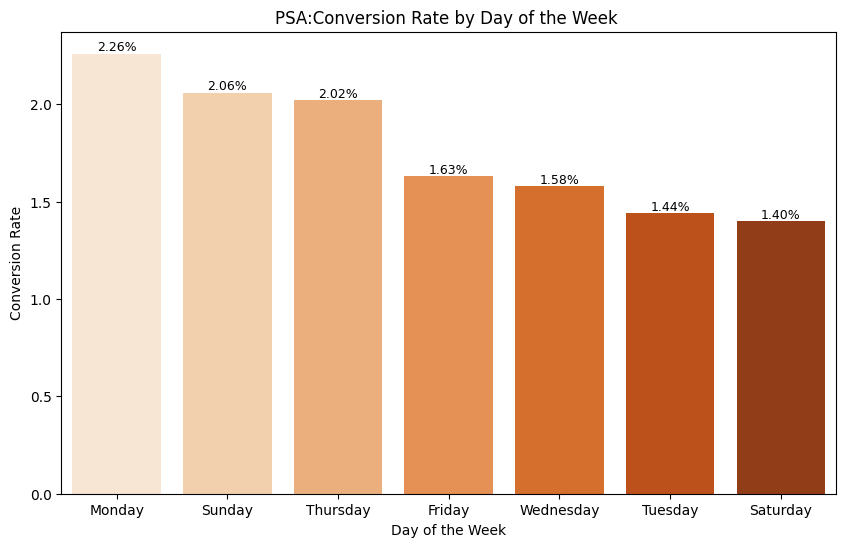

In [7]:
# psa group: conversion rate by day of the week 
query ="""
    SELECT 
      most_ads_day,
      round(avg(converted)*100,2) as conversion_rate
    FROM ab_testing
    where test_group = 'psa'
    group by 1
    order by 2 desc 
"""
df = pd.read_sql_query(query, conn)

#create figure
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x='most_ads_day', y='conversion_rate',order = df['most_ads_day'].tolist(),palette ='Oranges')
plt.title('PSA:Conversion Rate by Day of the Week ')
plt.xlabel('Day of the Week')
plt.ylabel('Conversion Rate')
for p in ax.patches:
    count = p.get_height()
    plt.annotate(f"{count:.2f}%", (p.get_x() + p.get_width() / 2, p.get_height()), 
                 ha='center', va='bottom',fontsize=9)
plt.show()

From the two plots, several business insights can be drawn:

-  Overall Performance – The conversion rate of the ad group is consistently higher than that of the PSA group across most time periods.

-  Shift in User Behavior Patterns – The introduction of the new ad appears to have influenced when users are most likely to convert. Specifically, the highest conversion rates for the ad group occur from Monday to Wednesday, whereas the PSA group’s peak conversion times are on Monday, Sunday, and Thursday.

These findings suggest that the new ad not only improves overall conversion but may also alter user engagement patterns throughout the week, which could be leveraged for optimized ad scheduling in future campaigns.

Now let's see the plots by hour of the day：

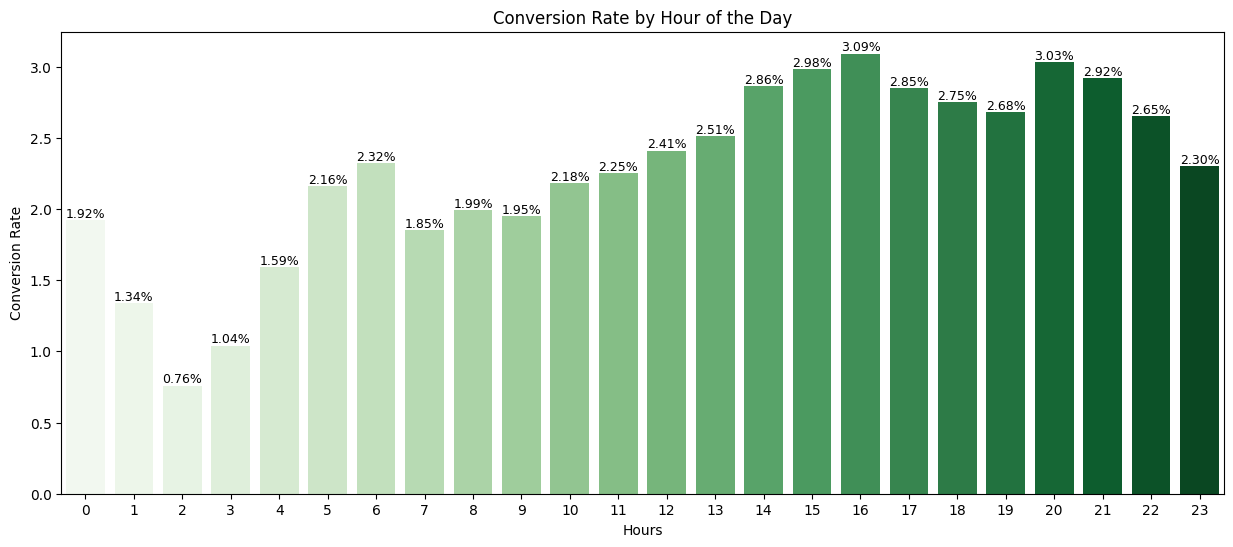

In [8]:
# ad:conversion rate by hour of the day 
query ="""
    SELECT 
      most_ads_hour,
      round(avg(converted)*100,2) as conversion_rate
    FROM ab_testing
    where test_group = 'ad' 
    group by 1
    order by 2 desc 
"""
df = pd.read_sql_query(query, conn)

#create figure
plt.figure(figsize=(15, 6))
ax = sns.barplot(data=df, x='most_ads_hour', y='conversion_rate',palette ='Greens')
plt.title('Conversion Rate by Hour of the Day')
plt.xlabel('Hours')
plt.ylabel('Conversion Rate')
for p in ax.patches:
    count = p.get_height()
    plt.annotate(f"{count:.2f}%", (p.get_x() + p.get_width() / 2, p.get_height()), 
                 ha='center', va='bottom',fontsize=9)
plt.show()

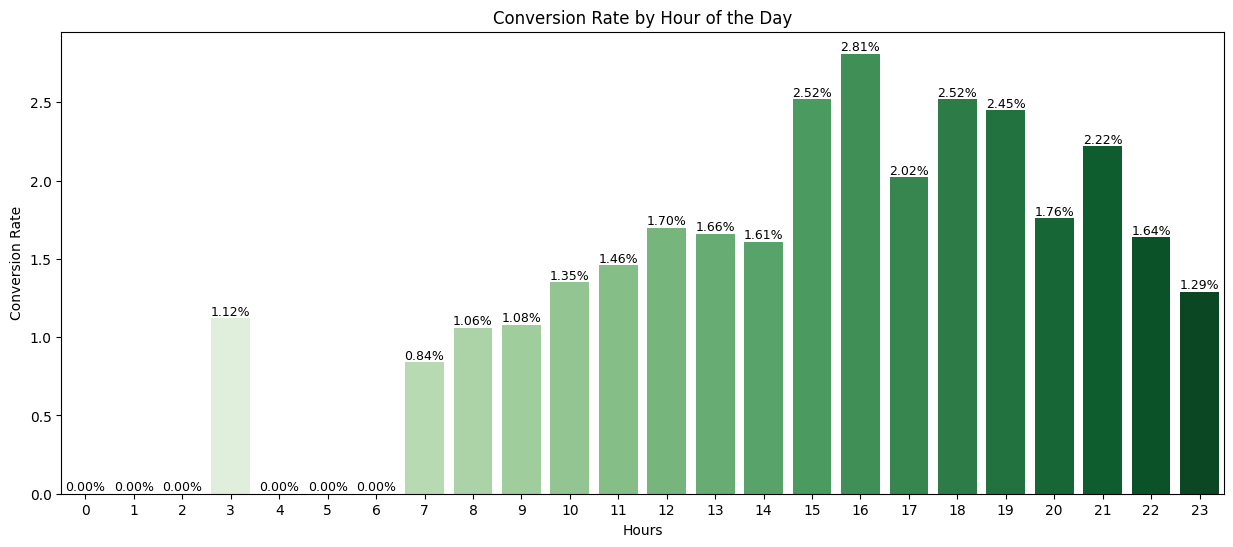

In [9]:
#psa: conversion rate by hour of the day 
query ="""
    SELECT 
      most_ads_hour,
      round(avg(converted)*100,2) as conversion_rate
    FROM ab_testing
    where test_group = 'psa' 
    group by 1
    order by 2 desc 
"""
df = pd.read_sql_query(query, conn)

#create figure
plt.figure(figsize=(15, 6))
ax = sns.barplot(data=df, x='most_ads_hour', y='conversion_rate',palette ='Greens')
plt.title('Conversion Rate by Hour of the Day')
plt.xlabel('Hours')
plt.ylabel('Conversion Rate')
for p in ax.patches:
    count = p.get_height()
    plt.annotate(f"{count:.2f}%", (p.get_x() + p.get_width() / 2, p.get_height()), 
                 ha='center', va='bottom',fontsize=9)
plt.show()

Similar to the day-of-week analysis, the ad group consistently outperforms the PSA group in the hour-of-day breakdown. The data indicates that the highest conversion rates for the ad group occur during two key time windows: afternoon hours between 2:00 PM and 5:00 PM (peaking at 4:00 PM) and evening hours between 8:00 PM and 10:00 PM (peaking at 8:00 PM).

These time patterns suggest that ad exposure during these periods may be particularly effective, providing valuable guidance for optimizing future ad placement schedules to maximize conversions.



### 3.4 Most Ads Seen by Day of the Week

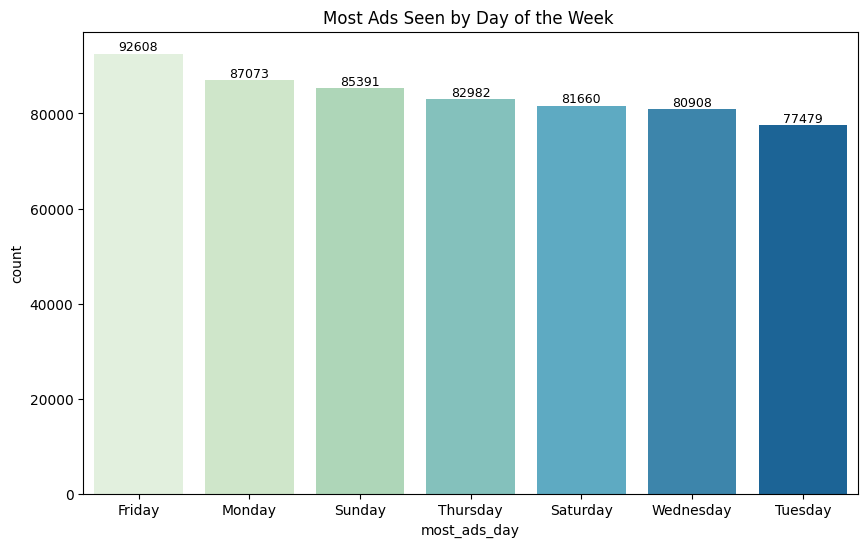

In [10]:
### Most Ads Seen by Day of the Week 
query = """
  SELECT 
  most_ads_day,
  count(*) as count
    FROM ab_testing
    group by 1
    order by 2 desc
"""

df = pd.read_sql_query(query, conn)

#create figure
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x='most_ads_day',y='count',order= df['most_ads_day'].tolist(),palette = 'GnBu')

for p in ax.patches:
    count = int(p.get_height())
    plt.annotate(count, (p.get_x() + p.get_width() / 2, p.get_height()), 
                 ha='center', va='bottom',fontsize=9)
plt.title('Most Ads Seen by Day of the Week ')
plt.show()

Interestingly, the data shows that Friday is the day with the highest number of ad impressions, which may be attributed to a higher ad delivery volume on that day. However, when compared with the conversion rate analysis, Friday’s conversion rate is relatively low. This suggests that Friday may not be the most effective day for ad placement. Instead, allocating more ad delivery to Monday, which shows a stronger conversion rate, could yield better results.

### 3.5 Top 10 Most Ads Seen by Day and Hour - Treatment vs. Control

In [11]:
### Ad: Top 10 most ads day and hours conversion rate
query = """
  SELECT 
  test_group,
  most_ads_day,
  most_ads_hour,
  round(avg(converted) * 100,2) || '%' as conv_rate
    FROM ab_testing
    where test_group = 'ad'
    group by 1,2,3
    order by 4 desc
    limit 10
  
"""
df = pd.read_sql_query(query, conn)
display(df)

,test_group,most_ads_day,most_ads_hour,conv_rate
0,ad,Saturday,5,5.68%
1,ad,Saturday,6,5.16%
2,ad,Tuesday,16,4.56%
3,ad,Monday,14,4.49%
4,ad,Sunday,20,4.37%
5,ad,Monday,15,4.29%
6,ad,Monday,6,4.2%
7,ad,Tuesday,15,4.12%
8,ad,Monday,16,3.74%
9,ad,Sunday,21,3.67%


In [12]:
#PSA: Top 10 most ads day and hours conversion rate
query = """
  SELECT 
  test_group,
  most_ads_day,
  most_ads_hour,
  round(avg(converted) * 100,2) || '%' as conv_rate
    FROM ab_testing
    where test_group = 'psa'
    group by 1,2,3
    order by 4 desc
    limit 10
"""
df = pd.read_sql_query(query, conn)
df

,test_group,most_ads_day,most_ads_hour,conv_rate
0,psa,Friday,19,3.89%
1,psa,Tuesday,16,3.77%
2,psa,Thursday,22,3.75%
3,psa,Saturday,7,3.7%
4,psa,Wednesday,16,3.7%
5,psa,Sunday,15,3.65%
6,psa,Friday,21,3.57%
7,psa,Sunday,16,3.52%
8,psa,Monday,19,3.51%
9,psa,Sunday,19,3.45%


This section presents a more granular analysis of conversion rates, offering insights for more precise ad targeting. The results reveal clear differences between the two groups: the ad group achieves its highest conversion rates on Saturday mornings at 5:00 AM and 6:00 AM, while the PSA group peaks on Friday at 7:00 PM and Tuesday at 4:00 PM.

These patterns highlight distinct user engagement behaviors for each group, which can be leveraged to schedule ad delivery during optimal time slots for maximum impact.

## <span style="color:White; font-size:24px; font-weight:bold;">4. Hypothesis testing </span>

### 4.1 Conversion Rate

The conversion rate is the primary metric in this analysis. As observed, the ad group achieved a conversion rate of 2.55%, compared to 1.75% for the PSA group. To determine whether this difference is statistically significant, a two-sample t-test was conducted.

 - Null Hypothesis (H₀): There is no significant difference in conversion rates between the ad group and the PSA group.

 - Alternative Hypothesis (H₁): There is a significant difference in conversion rates between the ad group and the PSA group.

This test evaluates whether the observed difference is likely due to random variation or reflects a true underlying effect of the ad on conversion performance.

In [13]:
#convert 'converted'col to integer
base_df['converted'] = base_df['converted'].astype(int)
base_df.head(10)

,index,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,0,1069124,ad,0,130,Monday,20
1,1,1119715,ad,0,93,Tuesday,22
2,2,1144181,ad,0,21,Tuesday,18
3,3,1435133,ad,0,355,Tuesday,10
4,4,1015700,ad,0,276,Friday,14
5,5,1137664,ad,0,734,Saturday,10
6,6,1116205,ad,0,264,Wednesday,13
7,7,1496843,ad,0,17,Sunday,18
8,8,1448851,ad,0,21,Tuesday,19
9,9,1446284,ad,0,142,Monday,14


In [14]:
# two variants
control_group = base_df[base_df['test_group'] == 'psa']
treatment_group = base_df[base_df['test_group'] == 'ad']

#Hypothesis on conversion rate
t_stat, p_val = stats.ttest_ind(treatment_group['converted'], control_group['converted'])
print(f"Hypothesis on conversion rate：T-statistic: {t_stat}, P-value: {p_val}")

Hypothesis on conversion rate：T-statistic: 7.370405974285658, P-value: 1.703305262783145e-13


In [15]:
if p_val < 0.05:
    print("Reject the null hypothesis: There is a significant difference in conversion rates between the 'ad' and 'psa' groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in conversion rates between the 'ad' and 'psa' groups.")

Reject the null hypothesis: There is a significant difference in conversion rates between the 'ad' and 'psa' groups.


Result: The p-value obtained from the two-sample t-test is below the chosen significance level, leading to the rejection of the null hypothesis. Therefore, we conclude that there is a statistically significant difference in conversion rates between the ad group and the PSA group.

The next metric to evaluate is the total number of ads seen by each group. Before selecting the appropriate statistical test, I first examined its distribution, as the two-sample t-test requires the data to be approximately normally distributed.

The histogram reveals a heavily right-skewed, long-tailed distribution, with the majority of values concentrated near zero and a small number of extreme high values (outliers) on the right. Given this violation of the normality assumption, I will use a non-parametric Mann–Whitney U test to compare the two groups.



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


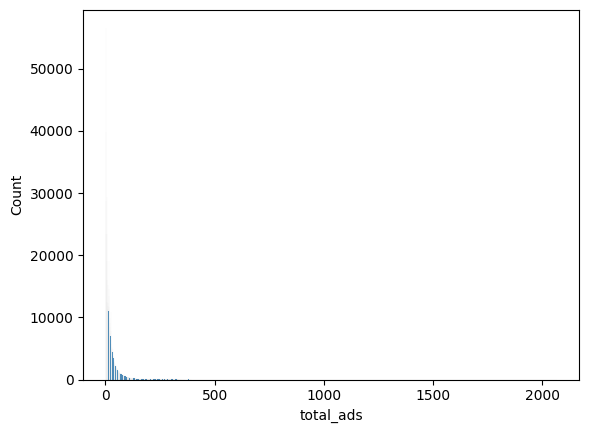

In [16]:
#check total ads distribution 
sns.histplot(base_df['total_ads'])
plt.show()

In [17]:
# Total Ads Analysis using mann-whitneyU
u_stat, p_val = stats.mannwhitneyu(treatment_group['total_ads'], 
                                   control_group['total_ads'],
                                   alternative='two-sided')
print(f"U-statistic: {u_stat}, P-value: {p_val}")


U-statistic: 6808288222.0, P-value: 4.6909108547205694e-11


In [18]:
if p_val < 0.05:
    print("Reject the null hypothesis: There is a significant difference in total ads between the 'ad' and 'psa' groups.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in total ads between the 'ad' and 'psa' groups.")

Reject the null hypothesis: There is a significant difference in total ads between the 'ad' and 'psa' groups.


Results: The Mann–Whitney U test results indicate a statistically significant difference in the total number of ads seen between the ad group and the PSA group. This suggests that, under comparable delivery conditions, users in the ad group were exposed to a significantly higher number of ads than those in the PSA group.

From a business perspective, this finding confirms that ad impressions were effectively delivered to the intended audience and that the treatment group received greater exposure, which may have contributed to the observed lift in conversion rates.

## <span style="color:White; font-size:24px; font-weight:bold;">5.Key Findings & Recommendations </span>

1. Statistical Results

 - Conversion Rate – The ad group achieved a conversion rate of 2.55%, compared to 1.79% for the PSA group. A two-sample t-test confirmed that this difference is statistically significant.

 - Ad Impressions – The total number of ads viewed per user was significantly higher for the ad group than for the PSA group, as verified by the Mann–Whitney U test. This indicates effective delivery and greater exposure to the treatment group.

2. Revenue Impact

 - Assuming a target audience of 500,000 users and an average revenue per conversion of 20 dollars, the conversion rate uplift of 0.76% translates into an estimated additional revenue of $76,000 if the ad campaign is launched.

3. Business Insights from EDA

 - Day-of-Week Patterns – The ad group’s peak conversion rates occurred from Monday to Wednesday, while the PSA group peaked on Monday, Sunday, and Thursday. Friday had the highest ad impressions but relatively low conversion rates, suggesting a less optimal day for ad delivery.

 - Hour-of-Day Patterns – The ad group achieved its highest conversion rates between 2:00–5:00 PM (peak at 4:00 PM) and 8:00–10:00 PM (peak at 8:00 PM). A more granular view also showed Saturday early mornings (5:00–6:00 AM) as top-performing time slots.

4. Recommendations

 - Launch the New Ad Campaign – The statistical evidence supports that the ad significantly outperforms the PSA in driving conversions.

 - Optimize Ad Scheduling – Reallocate ad delivery toward high-conversion periods (Monday–Wednesday, 2–5 PM, 8–10 PM, and Saturday early mornings) to maximize ROI.

 - Reduce Low-Impact Slots – Limit ad delivery on Friday despite high impressions, as conversion efficiency is low.